# TabM

This is a standalone usage example for the TabM project.
The easiest way to run it is [Pixi](https://pixi.sh/latest/#installation):

```shell
git clone https://github.com/yandex-research/tabm
cd tabm

# With GPU:
pixi run -e cuda jupyter-lab example.ipynb

# Without GPU:
pixi run jupyter-lab example.ipynb
```

For the full overview of the project, and for non-Pixi environment setups, see README in the repository:
https://github.com/yandex-research/tabm

In [3]:
# ruff: noqa: E402
import math
import random
import warnings
from typing import Literal, NamedTuple
import sklearn
import scipy

import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm
from torch.utils.data import Dataset
import pandas as pd
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import Counter

warnings.simplefilter('ignore')
from tabm_reference import Model, make_parameter_groups

warnings.resetwarnings()

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed + 1)
torch.manual_seed(seed + 2)
pass

# Dataset Class

In [5]:
CAT_TO_NUM_LABELS = {
    "Normal traffic": 0,
    "Suspicious traffic": 1,
    "DDoS attack": 2,
}

component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

attack_code_ports = {
    "ACK Attack": [],
    "CHARGEN": [19],
    "CLDAP": [389],
    "CoAP": [5683],
    "DNS": [53],
    "Generic UDP": [],
    "IPV4 fragmentation": [],
    "RDP": [3389],
    "RPC": [111, 135],
    "SNMP": [161, 162],
    "SYN Attack": [],
    "TCP Anomaly": [],
    "NTP": [123],
    "SSDP": [1900],
    "Sentinel": [],
    "Memcached": [11211],
    "RIP": [520],
    "TFTP": [69],
    "WSD": [3702],
}

# Port to attack mapping for fast lookup
port_to_attack = {}
for attack, ports in attack_code_ports.items():
    for port in ports:
        port_to_attack.setdefault(port, []).append(attack)

class DDoSDataset(Dataset):
    def __init__(self, split, use_inferred_atck_code):
        self.train_data_paths = [f'/home/appuser/data/train/SCLDDoS2024_SetA_events_extended.csv',
                                 f'/home/appuser/data/train/SCLDDoS2024_SetB_events_extended.csv']
        self.test_data_paths = [f'/home/appuser/data/test/SCLDDoS2024_SetC_events_extended.csv']     
        
        self.inferred_train_data_paths = [f'/home/appuser/data/train/A_B_inferred_attack_code.csv']
        self.inferred_test_data_paths = [f'/home/appuser/data/test/C_inferred_attack_code.csv']
        
        self.gen_data_paths = [f'/home/appuser/data/gen/SCLDDoS2024_SetD_events_extended.csv']
        
        self.inferred_gen_data_paths = [f'/home/appuser/data/gen/D_inferred_attack_code.csv']
        
        self.split = split   
        self.use_inferred_atck_code = use_inferred_atck_code
        
        if split == 'train':
            if use_inferred_atck_code:
                self.features, self.lables = self.load_data(self.inferred_train_data_paths, apply_smote=False)
            else:
                self.features, self.lables = self.load_data(self.train_data_paths, apply_smote=False)            
        elif split == 'test':
            if use_inferred_atck_code:
                self.features, self.lables = self.load_data(self.inferred_test_data_paths, apply_smote=False)
            else:
                self.features, self.lables = self.load_data(self.test_data_paths, apply_smote=False)
        elif split == 'gen':
            if use_inferred_atck_code:
                self.features, self.lables = self.load_data(self.inferred_gen_data_paths, apply_smote=False)
            else:
                self.features, self.lables = self.load_data(self.gen_data_paths, apply_smote=False)
        else:
            print("Invalid split. Use 'train' or 'test'")
            
    
    def get_ports(self):
        return self.ddos_ports
    
    
    def get_data(self):
        return self.features.numpy(), self.lables.numpy()
        
    # preload the data as it makes the training much faster (and it easily fits in memory)
    def load_data(self, data_paths, apply_smote=False, undersample=False, sample_factor=4):
        data = []
        
        for path in data_paths:
            event_df = pd.read_csv(path).fillna(0)
            data.append(event_df)

            # Attempt to load corresponding component file
            comp_path = path.replace('_events_extended.csv', '_components.csv')
            ref_event_path = path.replace('_events_extended.csv', '_events.csv')
        
        df = pd.concat(data, ignore_index=True)
            
        
        self.ddos_ports = df[df['Type'] == "DDoS attack"]["Port number"].unique()
        
        #feature_columns = df.columns[:19]  # All except the last column
        
        # comment this line I u need the frequency features
        df = df.loc[:, ~df.columns.str.contains('Ac')]
        feature_columns = df.columns[:-1]
        label_column = df.columns[-1]  # The last column
        
        # Convert categorical labels to numeric using the dictionary
        df[label_column] = df[label_column].map(CAT_TO_NUM_LABELS)
        
        # Check for missing or unknown labels
        if df[label_column].isna().any():
            print(df[label_column].isna().sum(), "missing labels")

        X = df[feature_columns]
        y = df[label_column]
        
        # one-hot encode the categorical features
        if self.use_inferred_atck_code:
            split_labels = X['Inferred Attack Code'].str.split('; ')
            mlb = MultiLabelBinarizer()
            attack_code_ohe = pd.DataFrame(mlb.fit_transform(split_labels),
                                        columns=[f"Inferred Attack Code_{cls}" for cls in mlb.classes_],
                                        index=X.index)

            # Drop the original column and join the new one-hot encoded columns
            X = X.drop(columns=['Inferred Attack Code'])
            X = X.join(attack_code_ohe)
            
            
            #X = pd.get_dummies(X, columns=["Inferred Attack Code"], drop_first=False)        
        
        self.columns = X.columns
        
        cols = list(X.columns)
        
        
        # Normalize the features
        #features = self.normalize(features)
        
        # Convert to PyTorch tensors
        if apply_smote and self.split == 'train':
            class_counts = Counter(y)
            sm = SMOTE(sampling_strategy={0: class_counts[0], 1:50000, 2:50000}, random_state=42)
            sm = SMOTE(sampling_strategy='not majority', random_state=42)
            sm = BorderlineSMOTE(sampling_strategy='not majority', random_state=42)
            X_resampled, y_resampled = sm.fit_resample(X.values, y.values)
            features = torch.tensor(X_resampled, dtype=torch.float32)
            labels = torch.tensor(y_resampled, dtype=torch.long)
        else:
            features = torch.tensor(X.values, dtype=torch.float32)
            labels = torch.tensor(y.values, dtype=torch.long)
        
        
        
        if undersample and self.split == 'train':
            # Undersample the majority class (label=0)
            class_0_indices = np.where(labels.cpu().numpy() == 0)[0]
            class_1_indices = np.where(labels.cpu().numpy() == 1)[0]
            class_2_indices = np.where(labels.cpu().numpy() == 2)[0]

            # Randomly undersample the majority class
            num_class_0_samples = sample_factor*(len(class_1_indices) + len(class_2_indices))  # Same number as the minority class
            class_0_indices_undersampled = np.random.choice(class_0_indices, num_class_0_samples, replace=False)

            # Concatenate indices of class 1, 2, and undersampled class 0
            undersampled_indices = np.concatenate([class_0_indices_undersampled, class_1_indices, class_2_indices])

            # Subset the dataset to include only the sampled indices
            features = features[undersampled_indices]
            labels = labels[undersampled_indices]

        return features, labels


    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.lables[idx]

        return x, y  # y is class index (long)

# Assemble the datatset

#### train and validation splits

In [6]:
TaskType = Literal['regression', 'binclass', 'multiclass']

# Classification.
n_classes = 3
assert n_classes >= 2
task_type: TaskType = 'binclass' if n_classes == 2 else 'multiclass'

dataset = DDoSDataset(split='train', use_inferred_atck_code=False)
X_cont = dataset.features.numpy()
Y = dataset.lables.numpy()

# >>> Continuous features.
X_cont: np.ndarray = X_cont.astype(np.float32)
n_cont_features = X_cont.shape[1]

# >>> Labels.
if task_type == 'regression':
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), 'Classification labels must form the range [0, 1, ..., n_classes - 1]'

# >>> Split the dataset.
all_idx = np.arange(len(Y))
train_idx, val_idx = sklearn.model_selection.train_test_split(
    all_idx, train_size=0.8
)

data_numpy = {
    'train': {'x_cont': X_cont[train_idx], 'y': Y[train_idx]},
    'val': {'x_cont': X_cont[val_idx], 'y': Y[val_idx]},
}

#### test split

In [7]:
# Add the Dataset C as the testing class

n_classes = 3
assert n_classes >= 2
task_type: TaskType = 'binclass' if n_classes == 2 else 'multiclass'

dataset = DDoSDataset(split='test', use_inferred_atck_code=False)
X_cont = dataset.features.numpy()
Y = dataset.lables.numpy()

# >>> Continuous features.
X_cont: np.ndarray = X_cont.astype(np.float32)
n_cont_features = X_cont.shape[1]

# >>> Labels.
if task_type == 'regression':
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), 'Classification labels must form the range [0, 1, ..., n_classes - 1]'
    
    
data_numpy['test'] = {'x_cont': X_cont, 'y': Y}

#### generalization split

In [8]:
n_classes = 3
assert n_classes >= 2
task_type: TaskType = 'binclass' if n_classes == 2 else 'multiclass'

dataset = DDoSDataset(split='gen', use_inferred_atck_code=False)
X_cont = dataset.features.numpy()
Y = dataset.lables.numpy()

# >>> Continuous features.
X_cont: np.ndarray = X_cont.astype(np.float32)
n_cont_features = X_cont.shape[1]

# >>> Labels.
if task_type == 'regression':
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), 'Classification labels must form the range [0, 1, ..., n_classes - 1]'
    
    
data_numpy['gen'] = {'x_cont': X_cont, 'y': Y}

# Data preprocessing

In [9]:
# Fit the QuantileTransformer on the training set.
X_cont_train_numpy = data_numpy['train']['x_cont']
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)
preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(train_idx) // 30, 1000), 10),
    output_distribution='normal',
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy


# Apply the preprocessing to the training, test and validation sets.
for part in data_numpy:
    # Transform only continuous features
    data_numpy[part]['x_cont'] = preprocessing.transform(
        data_numpy[part]['x_cont']
    )

    
regression_label_stats = None
Y_train = data_numpy['train']['y'].copy()

#  PyTorch settings

In [10]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Convert data to tensors
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}
Y_train = torch.as_tensor(Y_train, device=device)
if task_type == 'regression':
    for part in data:
        data[part]['y'] = data[part]['y'].float()
    Y_train = Y_train.float()

# Automatic mixed precision (AMP)
# torch.float16 is implemented for completeness,
# but it was not tested in the project,
# so torch.bfloat16 is used by default.
amp_dtype = (
    torch.bfloat16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else torch.float16
    if torch.cuda.is_available()
    else None
)
# Changing False to True will result in faster training on compatible hardware.
amp_enabled = False and amp_dtype is not None
grad_scaler = torch.cuda.amp.GradScaler() if amp_dtype is torch.float16 else None  # type: ignore

# torch.compile
compile_model = False

# fmt: off
print(
    f'Device:        {device.type.upper()}'
    f'\nAMP:           {amp_enabled} (dtype: {amp_dtype})'
    f'\ntorch.compile: {compile_model}'
)
# fmt: on

Device:        CUDA
AMP:           False (dtype: torch.bfloat16)
torch.compile: False


# Model

In [11]:
# Define the model
arch_type = 'tabm' # 'tabm' or 'tabm-mini' or 'tabm-packed'
bins = None

model = Model(
    n_num_features=data['train']['x_cont'].shape[1],
    cat_cardinalities=[],
    n_classes=n_classes,
    backbone={
        'type': 'MLP',
        'n_blocks': 3 if bins is None else 2,
        'd_block': 256,
        'dropout': 0.2,
        'n_blocks': 5
    },
    bins=bins,
    num_embeddings=(
        None
        if bins is None
        else {
            'type': 'PiecewiseLinearEmbeddings',
            'd_embedding': 16,
            'activation': False,
            'version': 'B',
        }
    ),
    arch_type=arch_type,
    k=48,
    share_training_batches=True,
).to(device)
optimizer = torch.optim.AdamW(make_parameter_groups(model), lr=1e-3, weight_decay=3e-4)

if compile_model:
    # NOTE
    # `torch.compile` is intentionally called without the `mode` argument
    # (mode="reduce-overhead" caused issues during training with torch==2.0.1).
    model = torch.compile(model)
    evaluation_mode = torch.no_grad
else:
    evaluation_mode = torch.inference_mode

#### Evalutation Functions

In [12]:
@torch.autocast(device.type, enabled=amp_enabled, dtype=amp_dtype)  # type: ignore[code]
def apply_model(part: str, idx: Tensor) -> Tensor:
    return (
        model(
            data[part]['x_cont'][idx],
            data[part]['x_cat'][idx] if 'x_cat' in data[part] else None,
        )
        .squeeze(-1)  # Remove the last dimension for regression tasks.
        .float()
    )


base_loss_fn = F.mse_loss if task_type == 'regression' else F.cross_entropy
#weight = torch.tensor([1.0, 1.0, 1.0], device=device)


def loss_fn(y_pred: Tensor, y_true: Tensor, weight: float = None) -> Tensor:
    # TabM produces k predictions. Each of them must be trained separately.
    # (regression)     y_pred.shape == (batch_size, k)
    # (classification) y_pred.shape == (batch_size, k, n_classes)
    k = y_pred.shape[-1 if task_type == 'regression' else -2]
    return base_loss_fn(
        y_pred.flatten(0, 1),
        y_true.repeat_interleave(k) if model.share_training_batches else y_true,
        weight=weight,
    )


@evaluation_mode()
def evaluate(part: str) -> float:
    model.eval()

    # When using torch.compile, you may need to reduce the evaluation batch size.
    eval_batch_size = 8096
    y_pred: np.ndarray = (
        torch.cat(
            [
                apply_model(part, idx)
                for idx in torch.arange(len(data[part]['y']), device=device).split(
                    eval_batch_size
                )
            ]
        )
        .cpu()
        .numpy()
    )
    if task_type == 'regression':
        # Transform the predictions back to the original label space.
        assert regression_label_stats is not None
        y_pred = y_pred * regression_label_stats.std + regression_label_stats.mean

    # Compute the mean of the k predictions.
    if task_type != 'regression':
        # For classification, the mean must be computed in the probabily space.
        y_pred = scipy.special.softmax(y_pred, axis=-1)
    y_pred = y_pred.mean(1)

    y_true = data[part]['y'].cpu().numpy()
    score = (
        -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5)
        if task_type == 'regression'
        else sklearn.metrics.f1_score(y_true, y_pred.argmax(1), average='macro')
    )
    return float(score)  # The higher -- the better.


print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.0059


# Training

In [ ]:
# Tensorboard for training
from torch.utils.tensorboard import SummaryWriter

run_name = "weights/TabM_no_frequ_features_extended_more_weight"
tb_log_dir = f'/home/appuser/src/logs/TabM/{run_name}'
writer = SummaryWriter(log_dir=tb_log_dir)

n_epochs = 1000

loss_weight = torch.tensor([1.0, 1.0, 3.141592], device=device)

train_size = len(train_idx)
batch_size = 256
epoch_size = math.ceil(train_size / batch_size)
best = {
    'val': -math.inf,
    'test': -math.inf,
    'epoch': -1,
}

# Early stopping: the training stops when
# there are more than `patience` consequtive bad updates.
patience = 1000
remaining_patience = patience

print('-' * 88 + '\n')
for epoch in range(n_epochs):
    batches = (
        torch.randperm(train_size, device=device).split(batch_size)
        if model.share_training_batches
        else [
            x.transpose(0, 1).flatten()
            for x in torch.rand((model.k, train_size), device=device)
            .argsort(dim=1)
            .split(batch_size, dim=1)
        ]
    )
    epoch_loss = 0.0
    epoch_num = 0
    for batch_idx in tqdm(batches, desc=f'Epoch {epoch}'):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model('train', batch_idx), Y_train[batch_idx], weight=loss_weight)
        epoch_loss += loss.item()
        epoch_num += 1
        if grad_scaler is None:
            loss.backward()
            optimizer.step()
        else:
            grad_scaler.scale(loss).backward()  # type: ignore
            grad_scaler.step(optimizer)
            grad_scaler.update()

    val_score = evaluate('val')
    test_score = evaluate('test')
    writer.add_scalar('validation_macro_F1', val_score, epoch+1)
    writer.add_scalar('test_macro_F1', test_score, epoch+1)
    writer.add_scalar('train_loss', epoch_loss/epoch_num, epoch+1)
    print(f'(val) {val_score:.4f} (test) {test_score:.4f}')

    if test_score > best['test']:
        print('🌸 New best epoch! 🌸')
        best = {'val': val_score, 'test': test_score, 'epoch': epoch}
        remaining_patience = patience
        torch.save(model.state_dict(), f"{run_name}.pth")
    else:
        remaining_patience -= 1

    if remaining_patience < 0:
        break

    print()
    if (epoch+1) % 30 == 0:
        loss_weight += torch.tensor([0.0, 0.0, 0.0], device=device)


print('\n\nResult:')
print(best)

# Inference  
! If you only want to run inference, make sure to run all of the blocks above (except for the training) !

Total parameters: 476960
------------------------------------------------------------------------------
Evaluating test set...


100%|██████████| 10834/10834 [00:07<00:00, 1372.69it/s]


Accuracy: 0.9909

Classification Report:
               precision    recall  f1-score        support
0              0.995851  0.995202  0.995526  125892.000000
1              0.907058  0.930537  0.918648    3052.000000
2              0.649338  0.651185  0.650260    1055.000000
accuracy       0.990892  0.990892  0.990892       0.990892
macro avg      0.850749  0.858975  0.854812  129999.000000
weighted avg   0.990954  0.990892  0.990920  129999.000000

F1 (Micro): 0.9909
F1 (Macro): 0.8548

Class-wise Accuracy (Recall):
 0    0.995202
1    0.930537
2    0.651185
Name: recall, dtype: float64


<Figure size 800x600 with 0 Axes>

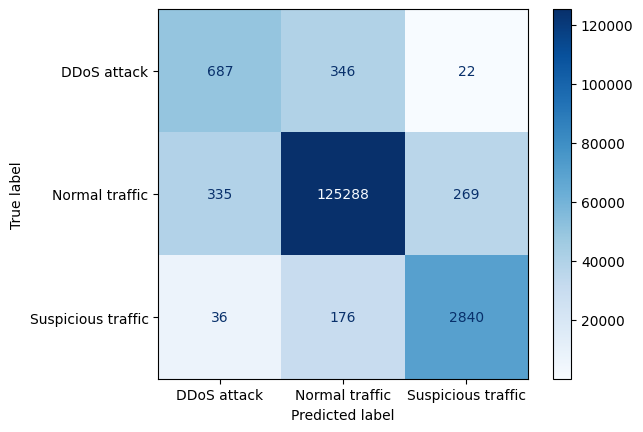

------------------------------------------------------------------------------
Evaluating gen set...


100%|██████████| 36470/36470 [00:24<00:00, 1461.43it/s]


Accuracy: 0.9182

Classification Report:
               precision    recall  f1-score      support
0              0.933465  0.986385  0.959195  394482.0000
1              0.377183  0.120039  0.182119   28424.0000
2              0.793139  0.632390  0.703701   14733.0000
accuracy       0.918200  0.918200  0.918200       0.9182
macro avg      0.701262  0.579605  0.615005  437639.0000
weighted avg   0.892611  0.918200  0.900124  437639.0000

F1 (Micro): 0.9182
F1 (Macro): 0.6150

Class-wise Accuracy (Recall):
 0    0.986385
1    0.120039
2    0.632390
Name: recall, dtype: float64


<Figure size 800x600 with 0 Axes>

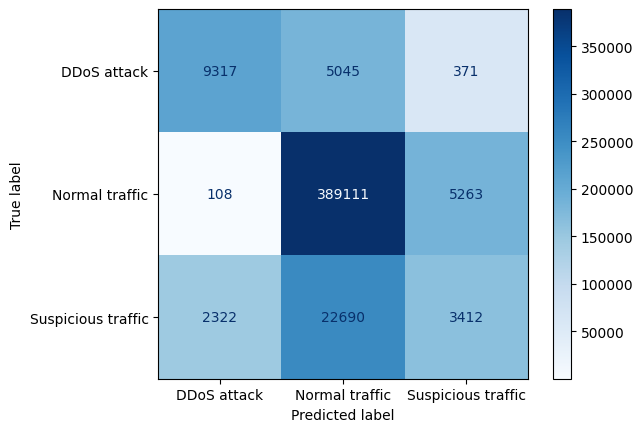

In [13]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)
import matplotlib.pyplot as plt

run_name = "weights/TabM_no_frequ_features_extended_more_weight"

model.load_state_dict(torch.load(f"{run_name}.pth"))
model.eval()

splits = ["test", "gen"]

eval_batch_size = 12

num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params}")

for part in splits:
    print("------------------------------------------------------------------------------")
    print(f"Evaluating {part} set...")
    y_pred_list = []
    for idx in tqdm(torch.arange(len(data[part]['y']), device=device).split(eval_batch_size)):
        with torch.no_grad():
            preds = apply_model(part, idx).cpu()
            probs = scipy.special.softmax(preds.numpy(), axis=-1)
            averaged = probs.mean(1)  # shape: [B, C]
            preds_class = np.argmax(averaged, axis=1)
            y_pred_list.append(preds_class)

    y_pred = np.concatenate(y_pred_list)

    y_test = data[part]['y'].cpu().numpy()

    # Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report (includes precision, recall, F1 per class + macro/micro)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("\nClassification Report:\n", report_df)

    # F1 scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"\nF1 (Micro): {f1_micro:.4f}")
    print(f"F1 (Macro): {f1_macro:.4f}")

    # Class-wise accuracy (same as recall per class)
    class_wise_accuracy = report_df.loc[[str(i) for i in np.unique(y_test)], "recall"]
    print("\nClass-wise Accuracy (Recall):\n", class_wise_accuracy)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reorder the confusion matrix so it matches the order of the labels for the other models
    new_order = [2, 0, 1]
    reordered_conf_matrix = conf_matrix[np.ix_(new_order, new_order)]

    # Corresponding class labels
    labels = ["DDoS attack", "Normal traffic", "Suspicious traffic"]

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=reordered_conf_matrix, display_labels=labels)
    disp.plot(cmap='Blues', values_format="d")
    plt.imshow(np.log1p(reordered_conf_matrix), cmap='Blues')  # Log transform for better visualization
    plt.show()